# PS____ : **San Francisco Crime Classification**

## >> **EDA & AUTO-ML (AUTOGLUON)**

## 00. **SET WORK ENVORINMENT**

#### 00.1. **DEFINE PRE-VARIABELS**

In [1]:
seed_num = 2024
compet_nm = 'SFCC'
run_time_limit = 60*60*12 # 8 hours

#### 00.2. **IMPORT PACKAGES AND SET OPTIONS**

In [2]:
#(1) Import packages
import os
import warnings
import datetime
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.tabular import TabularPredictor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import shap

#(2) Set options
warnings.filterwarnings(action='ignore')
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = '{:.4f}'.format
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
shap.initjs()

#### 00.3. **CREATE FUNCTIONS**

In [3]:
#(1) Create `display_both()` function
def display_both(train_df:pd.DataFrame, test_df:pd.DataFrame) :
    print('>> Display `train`')
    display(train_df)
    print(' ')
    print('>> Display `test`')
    display(test_df) 

#(2) Create `relocate_col()` function
def relocate_col(df:pd.DataFrame, tar_col:str, std_col:str, how:str='after') -> pd.DataFrame : 
    '''
    Reorder columns in a DataFrame by moving a target column relative to a standard column.

    Parameters :
    - df (pd.DataFrame): The DataFrame from which the column will be relocated.
    - tar_col (str): The name of the column to be relocated.
    - std_col (str): The column relative to which `tar_col` will be relocated.
    - how (str, optional): Specifies the placement of `tar_col` relative to `std_col`.
      It can be 'after' (default) or 'before'.

    Returns :
    - pd.DataFrame: A new DataFrame with the column `tar_col` relocated as specified.
    '''
    col_ary = np.array(object=df.columns)
    tar_col_idx = np.where(col_ary==tar_col)[0][0]
    std_col_idx = np.where(col_ary==std_col)[0][0]
    col_ary = np.delete(arr=col_ary, obj=tar_col_idx)
    if how == 'after' : 
        if std_col_idx == len(col_ary) : 
            col_ary = np.insert(arr=col_ary, obj=std_col_idx, values=tar_col)
        else :
            col_ary = np.insert(arr=col_ary, obj=std_col_idx+1, values=tar_col)
    elif how == 'before' : 
        if std_col_idx == 0 : 
            col_ary = np.insert(arr=col_ary, obj=std_col_idx, values=tar_col) 
        else : 
            col_ary = np.insert(arr=col_ary, obj=std_col_idx-1, values=tar_col)
    else : 
        pass
    df = df.loc[:, col_ary]
    return df 

#(3) Create `diagnose_df()` function
def diagnose_df(df:pd.DataFrame) -> pd.DataFrame : 
    '''
    Generates a diagnostic summary for a pandas DataFrame, reporting details like data types, 
    count of missing values, and uniqueness for each column.

    Parameters :
    - df (pd.DataFrame): The DataFrame to be diagnosed.

    Returns :
    - pd.DataFrame: A summary table with diagnostics for each column in the input DataFrame, 
      including the column name, data type, total rows, count and rate of missing values, 
      and count and rate of unique values.
    '''
    output = pd.DataFrame(data=df.dtypes).reset_index()
    output.columns = ['COLUMN_NM', 'DATA_TYPE']
    output.loc[:, 'ROW_CNT'] = len(df)
    output.loc[:, 'NA_CNT'] = df.isna().sum().values
    output.loc[:, 'NA_RATE'] = output.loc[:, 'NA_CNT'] / output.loc[:, 'ROW_CNT']
    output.loc[:, 'UNIQUE_CNT'] = df.nunique().values
    output.loc[:, 'UNIQUE_RATE'] = output.loc[:, 'UNIQUE_CNT'] / output.loc[:, 'ROW_CNT']
    format_columns = ['ROW_CNT', 'NA_CNT', 'UNIQUE_CNT']
    for col in format_columns:
        output[col] = output[col].apply(func=lambda x: f'{x:,.0f}')
    return output

#(4) Create `diagnose_num_df()` function
def diagnose_num_df(df:pd.DataFrame) -> pd.DataFrame : 
    '''
    Generates a diagnostic summary for numeric columns in a pandas DataFrame, including statistical 
    measures like mean, median, mode, and various percentiles.

    Parameters :
    - df (pd.DataFrame): The DataFrame to be diagnosed. Only numeric columns will be considered.

    Returns :
    - pd.DataFrame: A summary table with diagnostics for each numeric column in the input DataFrame, 
      including count, mean, standard deviation, min, max, median, mode, and various percentiles.
    '''
    df = df.select_dtypes(include='number')
    output = df.describe(include='all', percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).transpose()
    output.loc[:, 'median'] = df.median()
    output.loc[:, 'mode'] = df.mode().values[0]
    output = relocate_col(df=output, tar_col='median', std_col='mean', how='after')
    output = relocate_col(df=output, tar_col='mode', std_col='median', how='after')
    output.columns = np.array(object=list(map(np.char.upper, output.columns)))
    output = output.rename(columns={'COUNT' : 'ROW_CNT'})
    output['ROW_CNT'] = output['ROW_CNT'].astype(dtype='int')
    return output

#(5) Create `make_ndays()` function
def make_ndays(df:pd.DataFrame, tar_col:str) -> pd.DataFrame : 
    output = (datetime.datetime.now() - df.loc[:, tar_col]).dt.days
    return output

#(6) Create `split_dt()` function
def split_dt(df:pd.DataFrame, tar_col:str) -> pd.DataFrame :
    output = df.copy()
    output.loc[:, 'year'] = output.loc[:, tar_col].dt.strftime(date_format='%Y').astype(dtype='int')
    output.loc[:, 'month'] = output.loc[:, tar_col].dt.strftime(date_format='%m').astype(dtype='int')
    output.loc[:, 'day'] = output.loc[:, tar_col].dt.strftime(date_format='%d').astype(dtype='int')
    output.loc[:, 'hour'] = output.loc[:, tar_col].dt.strftime(date_format='%H').astype(dtype='int')
    output.loc[:, 'minute'] = output.loc[:, tar_col].dt.strftime(date_format='%M').astype(dtype='int')
    output = relocate_col(df=output, tar_col='year', std_col=tar_col, how='after')
    output = relocate_col(df=output, tar_col='month', std_col='year', how='after')
    output = relocate_col(df=output, tar_col='day', std_col='month', how='after')
    output = relocate_col(df=output, tar_col='hour', std_col='day', how='after')
    output = relocate_col(df=output, tar_col='minute', std_col='hour', how='after')
    # output = output.drop(labels=tar_col, axis=1)
    return output

#(4) Create `cleanse_addr()` function
def cleanse_addr(df:pd.DataFrame, tar_col:str) -> pd.DataFrame : 
    output = df.copy()
    output.loc[:, tar_col] = output.loc[:, tar_col].str.replace(pat=r'  ', repl=' ')
    output.loc[:, tar_col] = output.loc[:, tar_col].str.upper()
    return output

#(5) Create `detect_abbr()` function
def detect_abbr(value:str, pattern:dict) -> str :
    output = None  
    if not pd.isnull(obj=value) :
        address_upper = value.upper()
        for abbr, pattern in pattern.items():
            match = pattern.search(address_upper)
            if match :
                output = abbr
                break 
    if output in ['AVENUE', 'VIA'] :
        output = 'AV'
    elif output in ['WY'] : 
        output = 'WAY'
    elif output in ['HY'] : 
        output = 'HWY' 
    elif output in ['RW'] : 
        output = 'RD' 
    return output

#(6) Create `extract_abbr()` function
def extract_abbr(df:pd.DataFrame, tar_col:str, pattern:dict) -> pd.Series :
    output = df.loc[:, tar_col].apply(func=lambda x : detect_abbr(value=x, pattern=pattern))
    return output

#(7) Create `replace_outlier()` function
def replace_outlier(df:pd.DataFrame, tar_col:str, threshold:float=None, sign:str='left') -> pd.DataFrame :
    if sign == 'left' :
        if threshold == None : 
            num_cols = df.select_dtypes(include=['float', 'int']).columns
            diag_num_df = diagnose_num_df(df=df.loc[:, num_cols])
            CON = (df.loc[:, tar_col] > diag_num_df.loc[tar_col, '99%'] + 1)
        else : 
            CON = (df.loc[:, tar_col] > threshold)
    elif sign == 'right' : 
        if threshold == None : 
            num_cols = df.select_dtypes(include=['float', 'int']).columns
            diag_num_df = diagnose_num_df(df=df.loc[:, num_cols])
            CON = (df.loc[:, tar_col] < diag_num_df.loc[tar_col, '99%'] + 1)
        else : 
            CON = (df.loc[:, tar_col] < threshold)
    df.loc[CON, tar_col] = pd.NA
    chk_addr = df.loc[CON, 'Address'].unique()
    CON = (
        (df.loc[:, 'Address'].isin(values=chk_addr)) & 
        ~ (df.loc[:, tar_col].isna())
    )
    for addr, y_var in df.loc[CON, ['Address', tar_col]].set_index(keys='Address').to_dict()[tar_col].items() :
        CON = (
            (df.loc[:, tar_col].isna()) & 
            (df.loc[:, 'Address'] == addr)
        )
        df.loc[CON, tar_col] = y_var
    return df

#### 00.4. **CREATE CLASSES** (NO-USE)

In [4]:
#(1) Create `AutogluonWrapper`
class AutogluonWrapper:
    def __init__(self, predictor, feature_names, target_class=None):
        self.ag_model = predictor
        self.feature_names = feature_names
        self.target_class = target_class
        CON = (
            (target_class is None) and
            (predictor.problem_type != 'regression')
        )
        if CON :
            print(">> Since target_class not specified, SHAP will explain predictions for each class")
    
    def predict_proba(self, X) :
        if isinstance(X, pd.Series) :
            X = X.values.reshape(1,-1)
        if not isinstance(X, pd.DataFrame) :
            X = pd.DataFrame(data=X, columns=self.feature_names)
        preds = self.ag_model.predict_proba(X)
        CON = (
            (self.ag_model.problem_type == "regression") or 
            (self.target_class is None)
        )
        if CON :
            return preds
        else:
            return preds[self.target_class]   

<b></b>

## 01. **READ AND CONCATENATE DATASETS**

##### 01.1. **READ DATASETS**

In [5]:
train_raw = pd.read_table(filepath_or_buffer=f'{os.getcwd()}/../data/train.csv', sep=',')
test_raw = pd.read_table(filepath_or_buffer=f'{os.getcwd()}/../data/test.csv', sep=',')

<b></b>

## 02. **EDA**

#### 02.1. **CHECK DATASET SHAPE**

In [6]:
print(f'>> Train raw dataset shape : {train_raw.shape}')
print(f'>> Test raw dataset shape : {test_raw.shape}')

>> Train raw dataset shape : (878049, 9)
>> Test raw dataset shape : (884262, 7)


#### 02.2. **CHECK COLUMN NOT IN TEST**

In [7]:
CON = ~(np.isin(element=train_raw.columns, test_elements=test_raw.columns))
print(train_raw.columns[CON])

Index(['Category', 'Descript', 'Resolution'], dtype='object')


#### 02.3. **DIAGNOSE DATASETS**

##### 02.3.1. **CHECK NA, UNIQUE VALUE**

In [8]:
#(1) Diagnose `train_raw`
diag_train = diagnose_df(df=train_raw)

#(2) Display `diag_train`
display(diag_train)

,COLUMN_NM,DATA_TYPE,ROW_CNT,NA_CNT,NA_RATE,UNIQUE_CNT,UNIQUE_RATE
0,Dates,object,"878,049",0,0.0000,"389,257",0.4433
1,Category,object,"878,049",0,0.0000,39,0.0000
2,Descript,object,"878,049",0,0.0000,879,0.0010
3,DayOfWeek,object,"878,049",0,0.0000,7,0.0000
4,PdDistrict,object,"878,049",0,0.0000,10,0.0000
5,Resolution,object,"878,049",0,0.0000,17,0.0000
6,Address,object,"878,049",0,0.0000,"23,228",0.0265
7,X,float64,"878,049",0,0.0000,"34,243",0.0390
8,Y,float64,"878,049",0,0.0000,"34,243",0.0390


##### 02.3.2. **CHECK TARGET FREQUENCY**

- 클래스 불균형 문제 존재

In [9]:
#(1) Check frequency of target(`Category`) column
freq_cat = pd.DataFrame(data=train_raw.loc[:, 'Category'].value_counts()).reset_index()
freq_cat.loc[:, 'proportion'] = freq_cat.loc[:, 'count'] / len(train_raw)
freq_cat = freq_cat.rename(columns={'Category':'CATEGORY', 'count':'ROW_CNT', 'proportion':'PROPORTION'})

#(2) Display `freq_cat`
display(freq_cat)

,CATEGORY,ROW_CNT,PROPORTION
0,LARCENY/THEFT,174900,0.1992
1,OTHER OFFENSES,126182,0.1437
2,NON-CRIMINAL,92304,0.1051
3,ASSAULT,76876,0.0876
4,DRUG/NARCOTIC,53971,0.0615
5,VEHICLE THEFT,53781,0.0613
6,VANDALISM,44725,0.0509
7,WARRANTS,42214,0.0481
8,BURGLARY,36755,0.0419
9,SUSPICIOUS OCC,31414,0.0358


##### 02.3.3. **CHECK NUMERICAL VALUE**

- `X` : 평균-중앙값 비슷(대칭적 분포) / 이상치 존재 (ex. $ \, - 120.5 $)

- `Y` : 평균-중앙값 비슷(대칭적 분포) / 이상치 존재 (ex. $ \, 90 $)

In [10]:
#(1) Check numerical columns (descriptive statistics)
num_cols = train_raw.select_dtypes(include=['float', 'int']).columns

#(2) Diagnose number columns
diag_num_train = diagnose_num_df(df=train_raw.loc[:, num_cols])

#(3) display `diag_num_train`
display(diag_num_train)

,ROW_CNT,MEAN,MEDIAN,MODE,STD,MIN,1%,10%,25%,50%,75%,90%,99%,MAX
X,878049,-122.4226,-122.4164,-122.4034,0.0304,-122.5136,-122.5030,-122.4611,-122.4330,-122.4164,-122.4070,-122.3976,-122.3809,-120.5000
Y,878049,37.7710,37.7754,37.7754,0.4569,37.7079,37.7110,37.7282,37.7524,37.7754,37.7844,37.7915,37.8068,90.0000


In [11]:
#(3) Define condition
CON = (
    (train_raw.loc[:, 'X'] >= -120.5 - 1) |
    (train_raw.loc[:, 'Y'] >= 90 - 1)  
)

#(4) Display outliers
display(train_raw.loc[CON, :])

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
660485,2005-12-30 17:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,TENDERLOIN,NONE,5THSTNORTH ST / OFARRELL ST,-120.5000,90.0000
660711,2005-12-30 00:34:00,ASSAULT,INFLICT INJURY ON COHABITEE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5000,90.0000
660712,2005-12-30 00:34:00,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5000,90.0000
661106,2005-12-29 00:07:00,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Thursday,TENDERLOIN,PSYCHOPATHIC CASE,5THSTNORTH ST / EDDY ST,-120.5000,90.0000
666430,2005-11-30 11:25:00,OTHER OFFENSES,TRAFFIC VIOLATION,Wednesday,TENDERLOIN,"ARREST, CITED",5THSTNORTH ST / ELLIS ST,-120.5000,90.0000
...,...,...,...,...,...,...,...,...,...
844995,2003-06-11 08:49:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Wednesday,INGLESIDE,"ARREST, CITED",JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5000,90.0000
845842,2003-06-09 09:25:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Monday,INGLESIDE,"ARREST, CITED",JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5000,90.0000
852880,2003-05-02 01:00:00,SEX OFFENSES FORCIBLE,"FORCIBLE RAPE, BODILY FORCE",Friday,SOUTHERN,COMPLAINANT REFUSES TO PROSECUTE,3RD ST / JAMES LICK FREEWAY HY,-120.5000,90.0000
857248,2003-04-14 16:30:00,ROBBERY,"ROBBERY ON THE STREET, STRONGARM",Monday,BAYVIEW,COMPLAINANT REFUSES TO PROSECUTE,GILMAN AV / FITCH ST,-120.5000,90.0000


<b></b>

## 03. **CLEANSE DATASETS**

##### 03.1. **__ _init_ __**

- `Descript`, `Resolution` 열 삭제

- 중복 행 삭제

- `Dates` 열 데이터 형식 변경 : obj $ \rightarrow{} $ date

- `Category` 열 위치 변경

In [12]:
#(1) Copy datasets
train = train_raw.copy()
test = test_raw.copy()

#(2) Drop duplicated value
train = train.drop_duplicates()
# test = test.drop_duplicates()

#(3) Drop Not uesd columns
train = train.drop(labels=['Descript', 'Resolution'], axis=1)
test = test.drop(labels=['Id'], axis=1)

#(4) Relocate column
train = relocate_col(df=train, tar_col='Category', std_col=train.columns[-1], how='after')

#(5) Change data type
train['Dates'] = pd.to_datetime(arg=train['Dates'], errors='coerce')
test['Dates'] = pd.to_datetime(arg=test['Dates'], errors='coerce')

#(6) Display `train` and `test`
display_both(train_df=train, test_df=test)

>> Display `train`


,Dates,DayOfWeek,PdDistrict,Address,X,Y,Category
0,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.4259,37.7746,WARRANTS
1,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.4259,37.7746,OTHER OFFENSES
2,2015-05-13 23:33:00,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.4244,37.8004,OTHER OFFENSES
3,2015-05-13 23:30:00,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-122.4270,37.8009,LARCENY/THEFT
4,2015-05-13 23:30:00,Wednesday,PARK,100 Block of BRODERICK ST,-122.4387,37.7715,LARCENY/THEFT
...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,Monday,TARAVAL,FARALLONES ST / CAPITOL AV,-122.4590,37.7141,ROBBERY
878045,2003-01-06 00:01:00,Monday,INGLESIDE,600 Block of EDNA ST,-122.4474,37.7319,LARCENY/THEFT
878046,2003-01-06 00:01:00,Monday,SOUTHERN,5TH ST / FOLSOM ST,-122.4034,37.7803,LARCENY/THEFT
878047,2003-01-06 00:01:00,Monday,SOUTHERN,TOWNSEND ST / 2ND ST,-122.3905,37.7806,VANDALISM


 
>> Display `test`


,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.3996,37.7351
1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.3915,37.7324
2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.4260,37.7922
3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.4374,37.7214
4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.4374,37.7214
...,...,...,...,...,...,...
884257,2003-01-01 00:01:00,Wednesday,MISSION,2600 Block of BRYANT ST,-122.4090,37.7520
884258,2003-01-01 00:01:00,Wednesday,NORTHERN,1900 Block of WASHINGTON ST,-122.4253,37.7927
884259,2003-01-01 00:01:00,Wednesday,INGLESIDE,5500 Block of MISSION ST,-122.4454,37.7121
884260,2003-01-01 00:01:00,Wednesday,BAYVIEW,1500 Block of HUDSON AV,-122.3874,37.7395


#### 03.2. **HANDLE DATE**

##### 03.2.1. **MAKE N-DAYS**

In [13]:
#(1) Make `Ndays` columns
train.loc[:, 'Ndays'] = make_ndays(df=train, tar_col='Dates')
test.loc[:, 'Ndays'] = make_ndays(df=test, tar_col='Dates')

#(2) Relocate columns
train = relocate_col(df=train, tar_col='Ndays', std_col='DayOfWeek', how='after')
test = relocate_col(df=test, tar_col='Ndays', std_col='DayOfWeek', how='after')

#(3) Display `train` and `test`
display_both(train_df=train, test_df=test)

>> Display `train`


,Dates,DayOfWeek,Ndays,PdDistrict,Address,X,Y,Category
0,2015-05-13 23:53:00,Wednesday,3449,NORTHERN,OAK ST / LAGUNA ST,-122.4259,37.7746,WARRANTS
1,2015-05-13 23:53:00,Wednesday,3449,NORTHERN,OAK ST / LAGUNA ST,-122.4259,37.7746,OTHER OFFENSES
2,2015-05-13 23:33:00,Wednesday,3449,NORTHERN,VANNESS AV / GREENWICH ST,-122.4244,37.8004,OTHER OFFENSES
3,2015-05-13 23:30:00,Wednesday,3449,NORTHERN,1500 Block of LOMBARD ST,-122.4270,37.8009,LARCENY/THEFT
4,2015-05-13 23:30:00,Wednesday,3449,PARK,100 Block of BRODERICK ST,-122.4387,37.7715,LARCENY/THEFT
...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,Monday,7960,TARAVAL,FARALLONES ST / CAPITOL AV,-122.4590,37.7141,ROBBERY
878045,2003-01-06 00:01:00,Monday,7960,INGLESIDE,600 Block of EDNA ST,-122.4474,37.7319,LARCENY/THEFT
878046,2003-01-06 00:01:00,Monday,7960,SOUTHERN,5TH ST / FOLSOM ST,-122.4034,37.7803,LARCENY/THEFT
878047,2003-01-06 00:01:00,Monday,7960,SOUTHERN,TOWNSEND ST / 2ND ST,-122.3905,37.7806,VANDALISM


 
>> Display `test`


,Dates,DayOfWeek,Ndays,PdDistrict,Address,X,Y
0,2015-05-10 23:59:00,Sunday,3452,BAYVIEW,2000 Block of THOMAS AV,-122.3996,37.7351
1,2015-05-10 23:51:00,Sunday,3452,BAYVIEW,3RD ST / REVERE AV,-122.3915,37.7324
2,2015-05-10 23:50:00,Sunday,3452,NORTHERN,2000 Block of GOUGH ST,-122.4260,37.7922
3,2015-05-10 23:45:00,Sunday,3452,INGLESIDE,4700 Block of MISSION ST,-122.4374,37.7214
4,2015-05-10 23:45:00,Sunday,3452,INGLESIDE,4700 Block of MISSION ST,-122.4374,37.7214
...,...,...,...,...,...,...,...
884257,2003-01-01 00:01:00,Wednesday,7965,MISSION,2600 Block of BRYANT ST,-122.4090,37.7520
884258,2003-01-01 00:01:00,Wednesday,7965,NORTHERN,1900 Block of WASHINGTON ST,-122.4253,37.7927
884259,2003-01-01 00:01:00,Wednesday,7965,INGLESIDE,5500 Block of MISSION ST,-122.4454,37.7121
884260,2003-01-01 00:01:00,Wednesday,7965,BAYVIEW,1500 Block of HUDSON AV,-122.3874,37.7395


##### 03.2.2. **SPLIT DATE**

- `YYYY-mm-DD HH:MM:SS` $ \rightarrow{} $ `YYYY` / `mm` / `DD` / `HH` / `MM`

- 초 단위는 모두 "00"으로 기록되어 있으므로 삭제

In [14]:
#(1) Split columns
train = split_dt(df=train, tar_col='Dates')
test = split_dt(df=test, tar_col='Dates')

#(2) Display `train` and `test`
display_both(train_df=train, test_df=test)

>> Display `train`


,Dates,year,month,day,hour,minute,DayOfWeek,Ndays,PdDistrict,Address,X,Y,Category
0,2015-05-13 23:53:00,2015,5,13,23,53,Wednesday,3449,NORTHERN,OAK ST / LAGUNA ST,-122.4259,37.7746,WARRANTS
1,2015-05-13 23:53:00,2015,5,13,23,53,Wednesday,3449,NORTHERN,OAK ST / LAGUNA ST,-122.4259,37.7746,OTHER OFFENSES
2,2015-05-13 23:33:00,2015,5,13,23,33,Wednesday,3449,NORTHERN,VANNESS AV / GREENWICH ST,-122.4244,37.8004,OTHER OFFENSES
3,2015-05-13 23:30:00,2015,5,13,23,30,Wednesday,3449,NORTHERN,1500 Block of LOMBARD ST,-122.4270,37.8009,LARCENY/THEFT
4,2015-05-13 23:30:00,2015,5,13,23,30,Wednesday,3449,PARK,100 Block of BRODERICK ST,-122.4387,37.7715,LARCENY/THEFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,2003,1,6,0,15,Monday,7960,TARAVAL,FARALLONES ST / CAPITOL AV,-122.4590,37.7141,ROBBERY
878045,2003-01-06 00:01:00,2003,1,6,0,1,Monday,7960,INGLESIDE,600 Block of EDNA ST,-122.4474,37.7319,LARCENY/THEFT
878046,2003-01-06 00:01:00,2003,1,6,0,1,Monday,7960,SOUTHERN,5TH ST / FOLSOM ST,-122.4034,37.7803,LARCENY/THEFT
878047,2003-01-06 00:01:00,2003,1,6,0,1,Monday,7960,SOUTHERN,TOWNSEND ST / 2ND ST,-122.3905,37.7806,VANDALISM


 
>> Display `test`


,Dates,year,month,day,hour,minute,DayOfWeek,Ndays,PdDistrict,Address,X,Y
0,2015-05-10 23:59:00,2015,5,10,23,59,Sunday,3452,BAYVIEW,2000 Block of THOMAS AV,-122.3996,37.7351
1,2015-05-10 23:51:00,2015,5,10,23,51,Sunday,3452,BAYVIEW,3RD ST / REVERE AV,-122.3915,37.7324
2,2015-05-10 23:50:00,2015,5,10,23,50,Sunday,3452,NORTHERN,2000 Block of GOUGH ST,-122.4260,37.7922
3,2015-05-10 23:45:00,2015,5,10,23,45,Sunday,3452,INGLESIDE,4700 Block of MISSION ST,-122.4374,37.7214
4,2015-05-10 23:45:00,2015,5,10,23,45,Sunday,3452,INGLESIDE,4700 Block of MISSION ST,-122.4374,37.7214
...,...,...,...,...,...,...,...,...,...,...,...,...
884257,2003-01-01 00:01:00,2003,1,1,0,1,Wednesday,7965,MISSION,2600 Block of BRYANT ST,-122.4090,37.7520
884258,2003-01-01 00:01:00,2003,1,1,0,1,Wednesday,7965,NORTHERN,1900 Block of WASHINGTON ST,-122.4253,37.7927
884259,2003-01-01 00:01:00,2003,1,1,0,1,Wednesday,7965,INGLESIDE,5500 Block of MISSION ST,-122.4454,37.7121
884260,2003-01-01 00:01:00,2003,1,1,0,1,Wednesday,7965,BAYVIEW,1500 Block of HUDSON AV,-122.3874,37.7395


#### 03.3. **HANDLE ADDRESS**

##### 03.3.1. **CLEANSE ADDRESS**

- `[\s{2,}]` $ \rightarrow{} $ `[\s]`

- `[a-z]` $ \rightarrow{} $ `[A-Z]`

In [15]:
train = cleanse_addr(df=train, tar_col='Address')
test = cleanse_addr(df=test, tar_col='Address')

##### 03.3.2. **GROUP ABBREVIATION**

In [16]:
#(1) Make `abbrs_ptn`
abbrs = [
    'AL', 'AV', 'BL', 'CR', 'CT', 'DR', 'EX', 'HWY', 'HY',
    'LN', 'MAR', 'PARK', 'PL', 'PZ', 'RD', 'RW', 'ST', 'STWY',
    'TER', 'TR', 'WAY', 'WY', 'WK', 'AVENUE', 'VIA'
]
abbrs_ptn = {}
for chr in abbrs : 
    abbrs_ptn[chr] = re.compile(pattern=r'\b' + re.escape(chr) + r'\b')
abbrs_ptn['I'] = re.compile(pattern=r'I-\d{1,}')

#(2) Make `AddressAbbrs` columns
train.loc[:, 'AddressAbbrs'] = extract_abbr(df=train, tar_col='Address', pattern=abbrs_ptn)
test.loc[:, 'AddressAbbrs'] = extract_abbr(df=test, tar_col='Address', pattern=abbrs_ptn)

#(3) Relocate columns
train = relocate_col(df=train, tar_col='AddressAbbrs', std_col='Address', how='after')
test = relocate_col(df=test, tar_col='AddressAbbrs', std_col='Address', how='after')

#(4) Display `train` and `test`
display_both(train_df=train, test_df=test)

>> Display `train`


,Dates,year,month,day,hour,minute,DayOfWeek,Ndays,PdDistrict,Address,AddressAbbrs,X,Y,Category
0,2015-05-13 23:53:00,2015,5,13,23,53,Wednesday,3449,NORTHERN,OAK ST / LAGUNA ST,ST,-122.4259,37.7746,WARRANTS
1,2015-05-13 23:53:00,2015,5,13,23,53,Wednesday,3449,NORTHERN,OAK ST / LAGUNA ST,ST,-122.4259,37.7746,OTHER OFFENSES
2,2015-05-13 23:33:00,2015,5,13,23,33,Wednesday,3449,NORTHERN,VANNESS AV / GREENWICH ST,AV,-122.4244,37.8004,OTHER OFFENSES
3,2015-05-13 23:30:00,2015,5,13,23,30,Wednesday,3449,NORTHERN,1500 BLOCK OF LOMBARD ST,ST,-122.4270,37.8009,LARCENY/THEFT
4,2015-05-13 23:30:00,2015,5,13,23,30,Wednesday,3449,PARK,100 BLOCK OF BRODERICK ST,ST,-122.4387,37.7715,LARCENY/THEFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,2003,1,6,0,15,Monday,7960,TARAVAL,FARALLONES ST / CAPITOL AV,AV,-122.4590,37.7141,ROBBERY
878045,2003-01-06 00:01:00,2003,1,6,0,1,Monday,7960,INGLESIDE,600 BLOCK OF EDNA ST,ST,-122.4474,37.7319,LARCENY/THEFT
878046,2003-01-06 00:01:00,2003,1,6,0,1,Monday,7960,SOUTHERN,5TH ST / FOLSOM ST,ST,-122.4034,37.7803,LARCENY/THEFT
878047,2003-01-06 00:01:00,2003,1,6,0,1,Monday,7960,SOUTHERN,TOWNSEND ST / 2ND ST,ST,-122.3905,37.7806,VANDALISM


 
>> Display `test`


,Dates,year,month,day,hour,minute,DayOfWeek,Ndays,PdDistrict,Address,AddressAbbrs,X,Y
0,2015-05-10 23:59:00,2015,5,10,23,59,Sunday,3452,BAYVIEW,2000 BLOCK OF THOMAS AV,AV,-122.3996,37.7351
1,2015-05-10 23:51:00,2015,5,10,23,51,Sunday,3452,BAYVIEW,3RD ST / REVERE AV,AV,-122.3915,37.7324
2,2015-05-10 23:50:00,2015,5,10,23,50,Sunday,3452,NORTHERN,2000 BLOCK OF GOUGH ST,ST,-122.4260,37.7922
3,2015-05-10 23:45:00,2015,5,10,23,45,Sunday,3452,INGLESIDE,4700 BLOCK OF MISSION ST,ST,-122.4374,37.7214
4,2015-05-10 23:45:00,2015,5,10,23,45,Sunday,3452,INGLESIDE,4700 BLOCK OF MISSION ST,ST,-122.4374,37.7214
...,...,...,...,...,...,...,...,...,...,...,...,...,...
884257,2003-01-01 00:01:00,2003,1,1,0,1,Wednesday,7965,MISSION,2600 BLOCK OF BRYANT ST,ST,-122.4090,37.7520
884258,2003-01-01 00:01:00,2003,1,1,0,1,Wednesday,7965,NORTHERN,1900 BLOCK OF WASHINGTON ST,ST,-122.4253,37.7927
884259,2003-01-01 00:01:00,2003,1,1,0,1,Wednesday,7965,INGLESIDE,5500 BLOCK OF MISSION ST,ST,-122.4454,37.7121
884260,2003-01-01 00:01:00,2003,1,1,0,1,Wednesday,7965,BAYVIEW,1500 BLOCK OF HUDSON AV,AV,-122.3874,37.7395


In [17]:
#(6) Check frequency of `AddressAbbrs` column
freq_abbrs = pd.DataFrame(data=train.loc[:, 'AddressAbbrs'].value_counts()).reset_index()
freq_abbrs.loc[:, 'proportion'] = freq_abbrs.loc[:, 'count'] / len(train_raw)
freq_abbrs = freq_abbrs.rename(columns={'AddressAbbrs':'ABBRS', 'count':'ROW_CNT', 'proportion':'PROPORTION'})

#(7) Display `freq_abbrs`
display(freq_abbrs)

,ABBRS,ROW_CNT,PROPORTION
0,ST,617927,0.7038
1,AV,200417,0.2283
2,BL,21250,0.0242
3,DR,12826,0.0146
4,WAY,5277,0.0060
5,RD,3936,0.0045
6,CT,2956,0.0034
7,HWY,2689,0.0031
8,PZ,2349,0.0027
9,LN,1865,0.0021


#### 03.3. **REPLACE OUTLIER**

- `X` 및 `Y` 열 내 이상치 중 `Address` 열의 동일한 값이 존재한다면, 값으로 대치 

- `X` 및 `Y` 열 내 동일한 값이 존재하지 않다면, 직접 대치하지 않음 (autogluon의 내부 모델 군의 결측치 처리 방법으로 처리 ; ex. Xgboost's Learned Default Direction)

In [19]:
train = replace_outlier(df=train, tar_col='X', threshold=(-120.5-1), sign='left')
train = replace_outlier(df=train, tar_col='Y', threshold=(90-1), sign='left')
test = replace_outlier(df=test, tar_col='X', threshold=(-120.5-1), sign='left')
test = replace_outlier(df=test, tar_col='Y', threshold=(90-1), sign='left')

#### 03.4. **DIAGNOSE DATASETS**

In [20]:
#(1) Diagnose `train`
diagnose_df(df=train)

,COLUMN_NM,DATA_TYPE,ROW_CNT,NA_CNT,NA_RATE,UNIQUE_CNT,UNIQUE_RATE
0,Dates,datetime64[ns],"875,726",0,0.0000,"389,257",0.4445
1,year,int64,"875,726",0,0.0000,13,0.0000
2,month,int64,"875,726",0,0.0000,12,0.0000
3,day,int64,"875,726",0,0.0000,31,0.0000
4,hour,int64,"875,726",0,0.0000,24,0.0000
5,minute,int64,"875,726",0,0.0000,60,0.0001
6,DayOfWeek,object,"875,726",0,0.0000,7,0.0000
7,Ndays,int64,"875,726",0,0.0000,"2,572",0.0029
8,PdDistrict,object,"875,726",0,0.0000,10,0.0000
9,Address,object,"875,726",0,0.0000,"23,227",0.0265


In [21]:
#(2) Diagnose `test`
diagnose_df(df=test)

,COLUMN_NM,DATA_TYPE,ROW_CNT,NA_CNT,NA_RATE,UNIQUE_CNT,UNIQUE_RATE
0,Dates,datetime64[ns],"884,262",0,0.0000,"392,173",0.4435
1,year,int64,"884,262",0,0.0000,13,0.0000
2,month,int64,"884,262",0,0.0000,12,0.0000
3,day,int64,"884,262",0,0.0000,31,0.0000
4,hour,int64,"884,262",0,0.0000,24,0.0000
5,minute,int64,"884,262",0,0.0000,60,0.0001
6,DayOfWeek,object,"884,262",0,0.0000,7,0.0000
7,Ndays,int64,"884,262",0,0.0000,"2,588",0.0029
8,PdDistrict,object,"884,262",0,0.0000,10,0.0000
9,Address,object,"884,262",0,0.0000,"23,184",0.0262


<b></b>

## 04. **BUILD MODELS**

#### 04.1. **SET UP**

In [22]:
#(1) Define `req_dttm`
req_dttm = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

#(2) Define `predictor`
predictor = TabularPredictor(
    label='Category',
    eval_metric='log_loss',
    problem_type='multiclass',
    path=f'../temp/ATOGL_{req_dttm}'
)

#### 04.2. **FIT TRAIN DATASET**

In [23]:
predictor.fit(
    train_data=train,
    excluded_model_types=['KNN'],
    presets='best_quality',
    num_cpus='auto',
    num_gpus='auto',
    time_limit=run_time_limit,
    verbosity=2
)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Dynamic stacking is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
Detecting stacked overfitting by sub-fitting AutoGluon on the input data. That is, copies of AutoGluon will be sub-fit on subset(s) of the data. Then, the holdout validation data is used to detect stacked overfitting.
Sub-fit(s) time limit is: 43200 seconds.
Starting holdout-based sub-fit for dynamic stacking. Context path is: ../temp/ATOGL_20241022120440/ds_sub_fit/sub_fit_ho.
Beginning AutoGluon training ... Time limit = 10800s
AutoGluon will save models to "../temp/ATOGL_20241022120440/ds_sub_fit/sub_fit_ho"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.8.20
Operating System:   Darwin
Platform Machine:   arm64
Platfo

#### 04.3. **CHECK SCORE**

In [24]:
#(1) Check log_loss
predictor.leaderboard(extra_info=False)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-2.1000,log_loss,1257.5124,27096.3875,0.4105,934.1996,3,True,19
1,NeuralNetFastAI_BAG_L2,-2.1038,log_loss,1041.6618,24435.4859,7.3790,3695.3014,2,True,13
2,RandomForestGini_BAG_L2,-2.1950,log_loss,1193.7846,21788.1618,159.5018,1047.9773,2,True,16
3,RandomForestEntr_BAG_L2,-2.2199,log_loss,1090.2211,21418.9092,55.9383,678.7247,2,True,17
4,WeightedEnsemble_L2,-2.2442,log_loss,605.0581,4690.9272,0.4141,648.5625,2,True,12
5,XGBoost_BAG_L1,-2.2613,log_loss,516.3041,3400.0863,516.3041,3400.0863,1,True,9
6,NeuralNetTorch_BAG_L1,-2.2779,log_loss,3.1535,545.9059,3.1535,545.9059,1,True,10
7,RandomForestEntr_BAG_L1,-2.2822,log_loss,85.1863,96.3725,85.1863,96.3725,1,True,5
8,RandomForestGini_BAG_L1,-2.2851,log_loss,75.0409,91.6791,75.0409,91.6791,1,True,4
9,NeuralNetFastAI_BAG_L1,-2.3023,log_loss,3.7848,595.8370,3.7848,595.8370,1,True,1


In [25]:
#(2) Check weighted-f1
pred_tr = predictor.predict(data=train).values
f1_score(y_true=train.loc[:, 'Category'], y_pred=pred_tr, average='weighted')

0.41502952224233713

#### 04.4. **ANALYSIS TRAIN-ERROR (CONFUSION-MATRIX)**

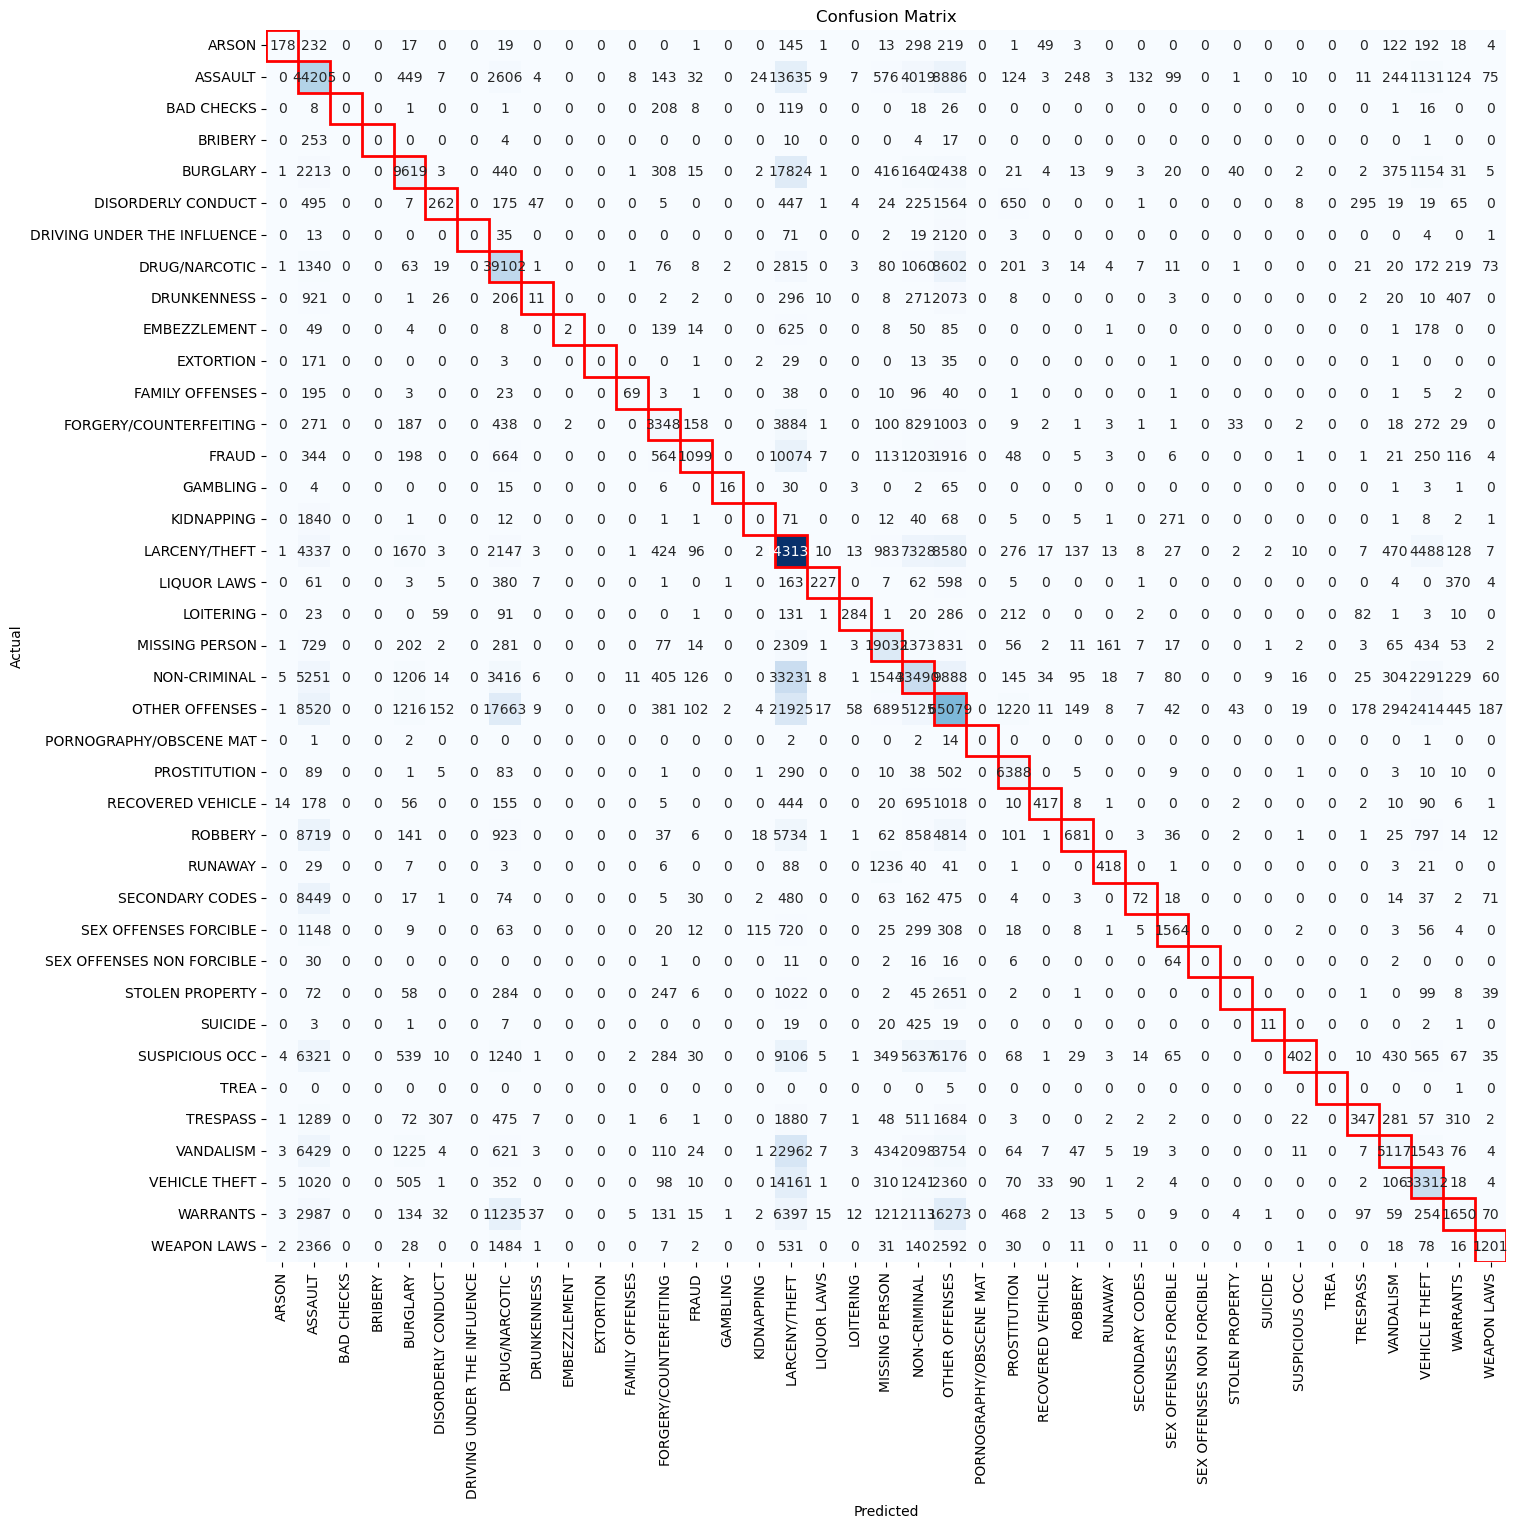

In [26]:
cm = confusion_matrix(
    y_true=train.loc[:, 'Category'], 
    y_pred=pred_tr
)
plt.figure(figsize=(16, 16))
plt.title(label='Confusion Matrix')
ax = sns.heatmap(
    data=cm, 
    annot=True, 
    fmt='d', 
    xticklabels=predictor.class_labels, 
    yticklabels=predictor.class_labels, 
    cmap='Blues',
    cbar=False
)
for i in range(len(cm)):
    ax.add_patch(p=plt.Rectangle(xy=(i, i), width=1, height=1, fill=False, edgecolor='red', lw=2))
plt.ylabel(ylabel='Actual')
plt.xlabel(xlabel='Predicted')
plt.show()

#### **(`PLUS`) CHECK PREPROCESSED DATA**

In [27]:
#(1) Make preprocessed train
train_X_pp = pd.DataFrame(data=predictor.transform_features(data=train))

#(2) Check Shape
train_X_pp.shape

(875726, 317)

In [28]:
#(3) Display `train_X_pp`
display(train_X_pp)

,year,month,day,hour,minute,Ndays,X,Y,DayOfWeek,PdDistrict,Address,AddressAbbrs,Dates,Dates.dayofweek,Address.char_count,Address.word_count,Address.capital_ratio,Address.digit_ratio,Address.special_ratio,Address.symbol_ratio.,Address.symbol_count./,Address.symbol_ratio./,__nlp__.100,__nlp__.1000,__nlp__.10th,...,__nlp__.st polk,__nlp__.st powell,__nlp__.st taylor,__nlp__.st vanness,__nlp__.stanyan,__nlp__.steiner,__nlp__.stevenson,__nlp__.stockton,__nlp__.sunnydale,__nlp__.sutter,__nlp__.taraval,__nlp__.taylor,__nlp__.the,__nlp__.townsend,__nlp__.treat,__nlp__.turk,__nlp__.union,__nlp__.valencia,__nlp__.vallejo,__nlp__.vanness,__nlp__.waller,__nlp__.washington,__nlp__.webster,__nlp__.wy,__nlp__._total_
0,2015,5,13,23,53,3449,-122.4259,37.7746,6,4,18187,15,1431561180000000000,2,0,2,7,0,8,8,1,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
1,2015,5,13,23,53,3449,-122.4259,37.7746,6,4,18187,15,1431561180000000000,2,0,2,7,0,8,8,1,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
2,2015,5,13,23,33,3449,-122.4244,37.8004,6,4,20611,1,1431559980000000000,2,7,2,9,0,1,1,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6
3,2015,5,13,23,30,3449,-122.4270,37.8009,6,4,4061,15,1431559800000000000,2,6,2,1,7,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9
4,2015,5,13,23,30,3449,-122.4387,37.7715,6,5,1731,15,1431559800000000000,2,7,2,6,3,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,2003,1,6,0,15,7960,-122.4590,37.7141,1,8,14720,1,1041812100000000000,0,8,2,9,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
878045,2003,1,6,0,1,7960,-122.4474,37.7319,1,2,10967,15,1041811260000000000,0,2,2,2,6,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
878046,2003,1,6,0,1,7960,-122.4034,37.7803,1,7,10798,15,1041811260000000000,0,0,2,6,1,8,8,1,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
878047,2003,1,6,0,1,7960,-122.3905,37.7806,1,7,20283,15,1041811260000000000,0,2,2,7,1,6,6,1,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5


<b></b>

## 05. **CHECK MODEL INTERPRETABILITY**

#### 05.1. **CHECK FEATURE-IMPORTANCE**

In [29]:
#(1) Print feature importance
display(predictor.feature_importance(data=train))

Computing feature importance via permutation shuffling for 13 features using 5000 rows with 5 shuffle sets...
	1105.95s	= Expected runtime (221.19s per shuffle set)
	547.96s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Address,0.8966,0.0163,0.0000,5,0.9301,0.8631
minute,0.4121,0.0100,0.0000,5,0.4328,0.3915
hour,0.2367,0.0126,0.0000,5,0.2626,0.2108
Y,0.2090,0.0051,0.0000,5,0.2195,0.1986
Dates,0.2044,0.0030,0.0000,5,0.2106,0.1981
X,0.1731,0.0067,0.0000,5,0.1868,0.1594
Ndays,0.1485,0.0038,0.0000,5,0.1563,0.1407
PdDistrict,0.1294,0.0037,0.0000,5,0.1371,0.1217
year,0.1171,0.0032,0.0000,5,0.1237,0.1105
day,0.0560,0.0012,0.0000,5,0.0585,0.0534


#### 05.2. **CHECK SHAP VALUE**

##### 05.2.1. **SET UP**

In [30]:
#(1) Define values
shap_samples = train_X_pp.shape[1] + 10
shap_baseline = train_X_pp.sample(n=100, random_state=seed_num)

#(2) Make objects
ag_wrapper = AutogluonWrapper(predictor=predictor, feature_names=train_X_pp.columns, target_class=train.loc[:, 'Category'].unique())
explainer = shap.KernelExplainer(model=ag_wrapper.predict_proba, data=shap_baseline)

#(3) Print base line value
print('>> Baseline prediction : ')
print(ag_wrapper.predict_proba(X=shap_baseline).mean())

>> Baseline prediction : 
WARRANTS                      0.0599
OTHER OFFENSES                0.1565
LARCENY/THEFT                 0.1376
VEHICLE THEFT                 0.0949
VANDALISM                     0.0512
NON-CRIMINAL                  0.0876
ROBBERY                       0.0266
ASSAULT                       0.0922
WEAPON LAWS                   0.0143
BURGLARY                      0.0436
SUSPICIOUS OCC                0.0428
DRUNKENNESS                   0.0050
FORGERY/COUNTERFEITING        0.0117
DRUG/NARCOTIC                 0.0564
STOLEN PROPERTY               0.0193
SECONDARY CODES               0.0128
TRESPASS                      0.0115
MISSING PERSON                0.0149
FRAUD                         0.0172
KIDNAPPING                    0.0039
RUNAWAY                       0.0009
DRIVING UNDER THE INFLUENCE   0.0043
SEX OFFENSES FORCIBLE         0.0061
PROSTITUTION                  0.0043
DISORDERLY CONDUCT            0.0045
ARSON                         0.0032
FAMILY OFFEN

##### 05.2.3. **DRAW FORCE PLOT (ONE-SAMPLE)**

- `force plot`은 **하나의 클래스(특정 범죄 유형)에 한정해 예측값과 특성 기여도를 시각화**하기 때문에, 실제 예측값과는 상이함 

$ \hspace{0.6cm} \, P(\text{Category}|X) \neq{} E(P(\text{Category}|X)) + \displaystyle\sum^{317}_{i=1}\phi{}_{i} = \text{SHAP}_{k} $

$ \hspace{0.6cm} \text{ where } \, P(\text{Category}|X)=f(X) \, \text{ is predict function}, \;\; \phi{} \, \text{ is shaply value}, \;\; i \, \text{ is feature index}, \;\; k \, \text{ is class index}. $

$ \hspace{0.6cm} \rightarrow{} $ 단순히 해당 열들의 값이 어떤 방향으로, 얼만큼 영향을 미쳤는지 파악하기 위함

In [31]:
#(1) Define row index
row_idx = 0

#(2) Calcul shap value
single_datapoint = train_X_pp.iloc[[row_idx], :]
single_prediction = ag_wrapper.predict_proba(X=single_datapoint) 
shap_values_single = explainer.shap_values(X=single_datapoint, nsamples=shap_samples)

  0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
#(3) Check predicted value
display(single_prediction.style.apply(func=lambda x : ['background-color: yellow' if v else '' for v in (x == x.max())], axis=1))

,WARRANTS,OTHER OFFENSES,LARCENY/THEFT,VEHICLE THEFT,VANDALISM,NON-CRIMINAL,ROBBERY,ASSAULT,WEAPON LAWS,BURGLARY,SUSPICIOUS OCC,DRUNKENNESS,FORGERY/COUNTERFEITING,DRUG/NARCOTIC,STOLEN PROPERTY,SECONDARY CODES,TRESPASS,MISSING PERSON,FRAUD,KIDNAPPING,RUNAWAY,DRIVING UNDER THE INFLUENCE,SEX OFFENSES FORCIBLE,PROSTITUTION,DISORDERLY CONDUCT,ARSON,FAMILY OFFENSES,LIQUOR LAWS,BRIBERY,EMBEZZLEMENT,SUICIDE,LOITERING,SEX OFFENSES NON FORCIBLE,EXTORTION,GAMBLING,BAD CHECKS,TREA,RECOVERED VEHICLE,PORNOGRAPHY/OBSCENE MAT
0,0.062264,0.155242,0.138624,0.066944,0.056737,0.120461,0.035172,0.079230,0.015717,0.057530,0.048067,0.007854,0.004580,0.031690,0.040172,0.008362,0.009723,0.010411,0.012408,0.001667,0.000390,0.010458,0.003347,0.004666,0.004493,0.006386,0.000354,0.002011,0.000271,0.000639,0.000899,0.000615,0.000147,0.000177,0.000102,0.000105,0.000009,0.002051,0.000025


In [33]:
#(4) display shap force-plots
print(f'>> Check Forceplot per class')
for label_idx in range(len(single_prediction.columns)) : 
    print(f'Label Name : "{single_prediction.columns[label_idx]}"')
    shap_plot = shap.force_plot(base_value=explainer.expected_value[label_idx], shap_values=shap_values_single[label_idx], features=train_X_pp.iloc[row_idx, :])
    display(shap_plot)

>> Check Forceplot per class
Label Name : "WARRANTS"


Label Name : "OTHER OFFENSES"


Label Name : "LARCENY/THEFT"


Label Name : "VEHICLE THEFT"


Label Name : "VANDALISM"


Label Name : "NON-CRIMINAL"


Label Name : "ROBBERY"


Label Name : "ASSAULT"


Label Name : "WEAPON LAWS"


Label Name : "BURGLARY"


Label Name : "SUSPICIOUS OCC"


Label Name : "DRUNKENNESS"


Label Name : "FORGERY/COUNTERFEITING"


Label Name : "DRUG/NARCOTIC"


Label Name : "STOLEN PROPERTY"


Label Name : "SECONDARY CODES"


Label Name : "TRESPASS"


Label Name : "MISSING PERSON"


Label Name : "FRAUD"


Label Name : "KIDNAPPING"


Label Name : "RUNAWAY"


Label Name : "DRIVING UNDER THE INFLUENCE"


Label Name : "SEX OFFENSES FORCIBLE"


Label Name : "PROSTITUTION"


Label Name : "DISORDERLY CONDUCT"


Label Name : "ARSON"


Label Name : "FAMILY OFFENSES"


Label Name : "LIQUOR LAWS"


Label Name : "BRIBERY"


Label Name : "EMBEZZLEMENT"


Label Name : "SUICIDE"


Label Name : "LOITERING"


Label Name : "SEX OFFENSES NON FORCIBLE"


Label Name : "EXTORTION"


Label Name : "GAMBLING"


Label Name : "BAD CHECKS"


Label Name : "TREA"


Label Name : "RECOVERED VEHICLE"


Label Name : "PORNOGRAPHY/OBSCENE MAT"


##### 05.2.4. **DRAW FORCE PLOT (N-SAMPLES)**

- 연산량이 많아 생략

In [34]:
#(1)
# shap_values = explainer.shap_values(X=train_X_pp, nsamples=shap_samples)

#(2)
# shap.force_plot(base_value=explainer.expected_value, shap_values=shap_values, features=X_test_pp)

##### 05.2.5. **DRAW SUMMARY PLOT (N-SAMPLES)**

- 연산량이 많아 생략

In [35]:
# shap.summary_plot(shap_values=shap_values, features=X_test_pp)

<b></b>

## 06. **PREDICT**

#### 06.1. **PREDICT TARGET**

In [3]:
#(1) Make `pred_te_proba`
pred_te_proba = pd.concat(
    objs=[
        test_raw.loc[:, 'Id'],
        pd.DataFrame(data=predictor.predict_proba(data=test).values, columns=predictor.class_labels)
    ],
    axis=1
)

#(2) Display `pred_te_proba`
display(pred_te_proba)

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0.005336,0.112953,0.000043,0.000353,0.057518,0.001914,0.001059,0.006501,0.001235,...,0.000074,0.001970,0.001153,0.048977,1.078325e-05,0.003775,0.095918,0.185284,0.017911,0.009349
1,1,0.001033,0.093954,0.000003,0.000902,0.000620,0.001692,0.009710,0.048566,0.008765,...,0.000049,0.003400,0.000029,0.048917,9.192476e-07,0.000645,0.015988,0.004298,0.114761,0.028004
2,2,0.003722,0.072830,0.000077,0.000105,0.080030,0.001109,0.000987,0.003523,0.002573,...,0.000027,0.004368,0.000394,0.032240,8.072248e-06,0.007494,0.086983,0.069911,0.009694,0.002850
3,3,0.002910,0.227193,0.000045,0.000544,0.040725,0.004741,0.001752,0.014672,0.007837,...,0.000049,0.003257,0.000437,0.056490,4.978040e-07,0.003814,0.120335,0.057432,0.031084,0.014438
4,4,0.002910,0.227193,0.000045,0.000544,0.040725,0.004741,0.001752,0.014672,0.007837,...,0.000049,0.003257,0.000437,0.056490,4.978040e-07,0.003814,0.120335,0.057432,0.031084,0.014438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884257,884257,0.000304,0.068955,0.007623,0.000156,0.016541,0.001947,0.000176,0.002413,0.000332,...,0.003283,0.002004,0.000251,0.106405,9.340285e-08,0.002279,0.022332,0.010825,0.003679,0.001946
884258,884258,0.000783,0.061317,0.009530,0.000139,0.073687,0.004197,0.000249,0.005554,0.000758,...,0.000711,0.002671,0.000497,0.078122,5.726565e-07,0.007155,0.040920,0.026187,0.008204,0.002025
884259,884259,0.000555,0.106334,0.005989,0.000232,0.014501,0.002328,0.000266,0.007550,0.001424,...,0.002922,0.004703,0.000331,0.087174,1.330617e-07,0.003188,0.023262,0.009440,0.012918,0.004206
884260,884260,0.001003,0.120153,0.005966,0.000705,0.022978,0.002232,0.000377,0.007250,0.001399,...,0.002122,0.003543,0.000607,0.087580,5.424307e-07,0.005320,0.033921,0.043008,0.011776,0.004994


#### 06.2. **WRITE PREDICT**

In [37]:
#(1) Define `submission_nm`
submission_nm = f'atogl_{req_dttm}'

#(2) Write `pred_te_proba`
pred_te_proba.to_csv(path_or_buf=f'../output/{compet_nm}_{submission_nm}.csv', index=False)